$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\R}{\bb{R}}$
$\newcommand{\der}[2]{\frac{ \mathrm{d} #1 }{ \mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{ \partial #1 }{ \partial #2 }}$
$\newcommand{\nrm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\abs}[1]{\left\vert #1 \right\vert}$

In [1]:
from keras.models import Model
from keras.layers import Add, Dense, Dot, Input, Reshape
from matplotlib.pyplot import figure, grid, legend, plot, show, title, xlabel, ylabel
from numpy import array, identity, linspace, product, sign, sin
from numpy.linalg import norm
from numpy.random import rand

from main import AffineDynamics, differentiate, FBLinController, LQRController, lqr_cost, MinNormController, RandomController, SystemDynamics, RoboticDynamics

Using TensorFlow backend.


# Inverted Pendulum (Robotic System)

Let $\mathcal{Q} \subseteq \R^n$ be a configuration space. Consider a robotic system governed by the differential equation:

\begin{equation}
    \mb{D}(\mb{q})\ddot{\mb{q}} + \mb{H}(\mb{q}, \dot{\mb{q}}) = \mb{B}\mb{u},
\end{equation}

for coordinates $\mb{q} \in \mathcal{Q}$, coordinate rates $\dot{\mb{q}} \in \R^n$, action $\mb{u} \in \R^m$, inertia matrix $\mb{D}: \mathcal{Q}_0 \to \bb{S}^n_{++}$, Coriolis and gravity terms $\mb{H}: \mathcal{Q} \times \R^n \to \R^n$, and static actuation matrix $\mb{B} \in \R^{n \times m}$. Here $\mathcal{Q}_0 \subseteq \mathcal{Q}$. We assume that any action in $\R^m$ is attainable, that $m = n$, and that $\mb{B}$ is full rank. As a first-order system, we have:

\begin{equation}
    \underbrace{\der{}{t} \begin{bmatrix} \mb{q} \\ \dot{\mb{q}} \end{bmatrix}}_{\dot{\mb{x}}} = \underbrace{\begin{bmatrix} \dot{\mb{q}} \\ -\mb{D}(\mb{q})^{-1}\mb{H}(\mb{q}, \dot{\mb{q}}) \end{bmatrix}}_{\mb{f}(\mb{x})} + \underbrace{\begin{bmatrix} \mb{0}_{n \times n} \\ \mb{D}(\mb{q})^{-1}\mb{B} \end{bmatrix}}_{\mb{g}(\mb{x})}\mb{u},
\end{equation}

for state $\mb{x} = (\mb{q}, \dot{\mb{q}})$. 

For example, consider an inverted pendulum modeled as follows:

- A massless rod of length $L$ is attached to a fixed base.
- A point mass $m$ is attached to the other end.
- Torque input $\tau$ is available at the base of the rod.

We measure the angle from upright $\theta$ and the corresponding rate $\dot{\theta}$. The kinetic energy of the system is $K = \frac{1}{2}ml^2 \dot{\theta}^2$ and the potential energy is $U = mgl\cos{\theta}$, yielding Lagrangian $L = K - U = \frac{1}{2}ml^2\dot{\theta}^2 - mgl\cos{\theta}$. The dynamics are given by:

\begin{align}
    \der{}{t}\left(\derp{L}{\dot{\theta}}\right) - \derp{L}{\theta} &= \der{}{t}(ml^2\dot{\theta}) - mgl\sin{\theta}\\
    &= ml^2\ddot{\theta} - mgl\sin{\theta}\\
    &= \tau,
\end{align}

representable as:

\begin{equation}
    \underbrace{ml^2}_{\mb{D}(\mb{q})}\underbrace{\ddot{\theta}}_{\ddot{\mb{q}}} +  \underbrace{(-mgl\sin{\theta}) }_{\mb{H}(\mb{q}, \dot{\mb{q}})}= \underbrace{1}_{\mb{B}} \underbrace{\tau}_{\mb{u}}
\end{equation}

for $q = \theta$ and $\dot{q} = \dot{\theta}$, or as:

\begin{equation}
    \underbrace{\der{}{t} \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix}}_{\dot{\mb{x}}} = \underbrace{\begin{bmatrix} \dot{\theta} \\ \frac{g}{l}\sin{\theta} \end{bmatrix}}_{\mb{f}(\mb{x})} + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{ml^2} \end{bmatrix}}_{\mb{g}(\mb{x})} \underbrace{\tau}_{\mb{u}}
\end{equation}

for $\mb{x} = (q, \dot{q})$. Suppose $m = 0.25$ and $l = 0.5$.

In [2]:
n = 1

class InvertedPendulum(SystemDynamics, RoboticDynamics):
    def __init__(self, m, l, g=9.81):
        SystemDynamics.__init__(self, 2 * n, n)
        RoboticDynamics.__init__(self, n)
        self.params = m, l, g
    
    def drift(self, x, t):
        _, l, g = self.params
        theta, theta_dot = x
        return array([theta_dot, g * sin(theta) / l])
    
    def act(self, x, t):
        m, l, _ = self.params
        return array([[0], [1 / (m * (l ** 2))]])
    
m, l, g = 0.25, 0.5, 9.81
system = InvertedPendulum(m, l, g)

Because the robotic system dynamics are in general nonlinear, we cannot tractably solve the infinite-horizon optimal control problem we could solve for [controllable linear systems](linear-system.ipynb). However, we can synthesize a Lyapunov function and a corresponding greedy optimal controller that stabilizes the system exponentially. First, consider the linearizing feedback controller:

\begin{equation}
    \mb{u}_{LF}(\mb{x}, \bs{\nu}) = \left( \mb{D}(\mb{q})^{-1}\mb{B} \right)^{-1} \left( \mb{D}(\mb{q})\mb{H}(\mb{q}, \dot{\mb{q}}) + \bs{\nu} \right),
\end{equation}

where $\mb{D}(\mb{q})^{-1}\mb{B}$ is invertible for all $\mb{q} \in \mathcal{Q}_0$ since $D(\mb{q}) \in \bb{S}^n_{++}$ and $\mb{B}$ is full rank, and $\bs{\nu}$ is any auxilliary control input. Using this controller induces dynamics:

\begin{equation}
    \der{}{t} \begin{bmatrix} \mb{q} \\ \dot{\mb{q}} \end{bmatrix} = \underbrace{\begin{bmatrix} \mb{0}_{n \times n} & \mb{I}_{n \times n} \\ \mb{0}_{n \times n} & \mb{0}_{n \times n} \end{bmatrix}}_{\mb{F}} \begin{bmatrix} \mb{q} \\ \dot{\mb{q}} \end{bmatrix} + \underbrace{\begin{bmatrix} \mb{0}_{n \times n} \\ \mb{I}_{n \times n} \end{bmatrix}}_{\mb{G}} \bs{\nu}.
\end{equation}

Since the first two blocks of the associated Kalman controllability matrix satisfy:

\begin{equation}
    \begin{bmatrix} \mb{G} & \mb{F}\mb{G} \end{bmatrix} = \begin{bmatrix} \mb{0}_{n \times n} & \mb{I}_{n \times n} \\ \mb{I}_{n \times n} & \mb{0}_{n \times n} \end{bmatrix},
\end{equation}

which is full rank, the pair $(\mb{F}, \mb{G})$ is controllable. Therefore, for any $\mb{Q} \in \bb{S}^{2n}_{++}$ and $\mb{R} \in \bb{S}^n_{++}$, there is a unique $\mb{P} \in \bb{S}^{2n}_{++}$ satisfying the continuous-time algebraic Riccati equation (CARE):

\begin{equation}
    \mb{F}^\top\mb{P} + \mb{P}\mb{F} - \mb{P}\mb{G}\mb{R}^{-1}\mb{G}^\top\mb{P} = -\mb{Q}.
\end{equation}

This yields a control Lyapunov function (CLF) $V: \mathcal{Q} \times \R^n \to \R_+$ specified as $V(\mb{x}) = \mb{x}^\top\mb{P}\mb{x}$ for all states $\mb{x} \in \mathcal{Q} \times \R^n$. To see that this is a CLF, note that:

\begin{align}
    \dot{V}(\mb{x}, \mb{u}_{LF}(\mb{x}, \bs{\nu})) &= \dot{\mb{x}}^\top\mb{P}\mb{x} + \mb{x}^\top\mb{P}\dot{\mb{x}}\\
    &= \mb{x}^\top(\mb{F}^\top\mb{P} + \mb{P}\mb{F})\mb{x} + 2\mb{x}^\top\mb{P}\mb{G}\bs{\nu}\\
    &= -\mb{x}^\top\mb{Q}\mb{x} + \mb{x}^\top\mb{P}\mb{G}\mb{R}^{-1}\mb{G}^\top\mb{P}\mb{x} + 2\mb{x}^\top\mb{P}\mb{G}\bs{\nu},
\end{align}

and picking $\bs{\nu}_0 = -\frac{1}{2}\mb{R^{-1}}\mb{G}^\top\mb{P}\mb{x}$ yields:

\begin{equation}
    \dot{V}(\mb{x}, \mb{u}_{LF}(\mb{x}, \bs{\nu}_0)) = -\mb{x}^\top\mb{Q}\mb{x}.
\end{equation}

Note that $\bs{\nu}_0$ is the LQR controller associated with the induced linear dynamics. To meet this stability criterion with lower control cost, we specify instead a quadratic program (QP) CLF controller given by:

\begin{align}
    \mb{u}_{QP}(\mb{x}) = \inf_{\mb{u} \in \R^n} ~&~ \mb{u}^\top\mb{R}\mb{u}\\
    \mathrm{s.t.} ~&~ \dot{V}(\mb{x}, \mb{u}) \leq -\mb{x}^\top\mb{Q}\mb{x}.
\end{align}

The inequality constraint is affine in $\mb{u}$, since in general:

\begin{equation}
    \dot{V}(\mb{x}, \mb{u}) = \nabla V(\mb{x})^\top\mb{f}(\mb{x}) + \nabla V(\mb{x})^\top\mb{g}(\mb{x})\mb{u}.
\end{equation}

Since the linearizing feedback controller with auxilliary control $\bs{\nu}$ always satisfies the inequality constraint, this problem is feasible for all $\mb{x} \in \mathcal{Q}_0 \times \R^n$.

The associated Lagrangian is:

\begin{equation}
    \mathcal{L}(\mb{u}, \lambda; \mb{x}) = \mb{u}^\top\mb{R}\mb{u} + \lambda (\dot{V}(\mb{x}, \mb{u}) + \mb{x}^\top\mb{Q}\mb{x}),
\end{equation}

which is minimized at $\mb{u}^*(\lambda; \mb{x})$ satisfying:

\begin{equation}
    \derp{}{\mb{u}} \mathcal{L}(\mb{u}^*(\lambda; \mb{x}), \lambda; \mb{x}) = 2\mb{R}\mb{u}^*(\lambda; \mb{x}) + \lambda \mb{g}(\mb{x})^\top\nabla V(\mb{x}) = \mb{0}_n,
\end{equation}

therefore the optimal control satisfies:

\begin{equation}
    \mb{u}^*(\lambda; \mb{x}) = -\frac{\lambda}{2}\mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x}).
\end{equation}

The dual function is therefore:

\begin{align}
    h(\lambda; \mb{x}) &= \inf_{\mb{u} \in \R^m} \mathcal{L}(\mb{u}, \lambda; \mb{x})\\
    &= \mathcal{L}(\mb{u}^*(\lambda; \mb{x}), \lambda; \mb{x})\\
    &= -\frac{\lambda}{2} \mb{u}^*(\lambda; \mb{x})^\top\mb{g}(\mb{x})^\top\nabla V(\mb{x}) + \lambda \dot{V}(\mb{x}, \mb{0}_n) - \frac{\lambda^2}{2}\nabla V(\mb{x})^\top\mb{g}(\mb{x})\mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x}) + \lambda\mb{x}^\top\mb{Q}\mb{x}\\
    &= -\frac{\lambda^2}{4} \nabla V(\mb{x})^\top\mb{g}(\mb{x})\mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x}) + \lambda( \dot{V}(\mb{x}, \mb{0}_n) + \mb{x}^\top\mb{Q}\mb{x} ),
\end{align}

which in turn is maximized at $\lambda^*(\mb{x})$ satisfying:

\begin{equation}
    \derp{}{\lambda} h(\lambda^*(\mb{x}); \mb{x}) = - \frac{\lambda^*(\mb{x})}{2} \nabla V(\mb{x})^\top\mb{g}(\mb{x})\mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x}) + \dot{V}(\mb{x}, \mb{0}_n) + \mb{x}^\top\mb{Q}\mb{x} = 0.
\end{equation}

if $\lambda^*(\mb{x}) \geq 0$; otherwise $\lambda^*(\mb{x}) = 0$. Therefore:

\begin{equation}
    \lambda^*(\mb{x}) = \begin{cases}
        2 \frac{\dot{V}(\mb{x}, \mb{0}_n) + \mb{x}^\top\mb{Q}\mb{x}}{\nabla V(\mb{x})^\top\mb{g}(\mb{x})\mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x})} & \dot{V}(\mb{x}, \mb{0}_n) \geq -\mb{x}^\top\mb{Q}\mb{x} \\
        0 & \dot{V}(\mb{x}, \mb{0}_n) < -\mb{x}^\top\mb{Q}\mb{x}
    \end{cases},
\end{equation}

noting that $\nabla V(\mb{x})^\top\mb{g}(\mb{x})\mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x}) \geq 0$ since $\mb{R}$ is positive-definite. Ultimately, this yields optimal controller:

\begin{equation}
    \mb{u}_{QP}(\mb{x}) = \mb{u}^*(\lambda^*(\mb{x}); \mb{x}) = \begin{cases}
        -\frac{\dot{V}(\mb{x}, \mb{0}_n) + \mb{x}^\top\mb{Q}\mb{x}}{\nabla V(\mb{x})^\top\mb{g}(\mb{x})\mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x})} \mb{R}^{-1}\mb{g}(\mb{x})^\top\nabla V(\mb{x}) & \dot{V}(\mb{x}, \mb{0}_n) \geq -\mb{x}^\top\mb{Q}\mb{x}\\
        \mb{0}_n & \dot{V}(\mb{x}, \mb{0}_n) < -\mb{x}^\top\mb{Q}\mb{x}
    \end{cases}.
\end{equation}
Intuitively, the QP controller takes no action if the system meets the stability requirement without control, and takes the minimum cost action to satisfy the requirement if the system does not.

For the inverted pendulum system we build linearizing feedback and QP controllers, both with $\mb{Q} = \mb{I}_2$ and $R = 1$.

In [3]:
Q = identity(2 * n)
R = identity(n)

lqr = LQRController.build(system, Q, R)
fb_lin = FBLinController(system, lqr)

qp = MinNormController.build(system, Q, R)

We simulate the system for $T = 10$ seconds with both controllers, starting from rest an $\theta = 1$. We compare the running costs:

\begin{equation}
    \int_0^t (\mb{x}(s)^\top\mb{Q}\mb{x}(s) + \mb{u}(s)^\top\mb{R}\mb{u}(s)) \mathrm{d}s,
\end{equation}

for $0 \leq t \leq T$. The controllers are implemented discretely with sampling freqencies of $100$ Hz.

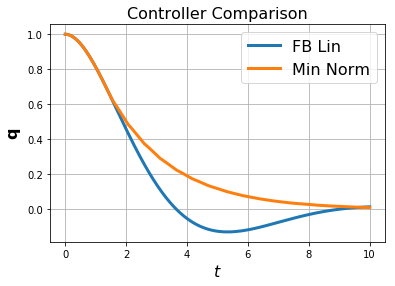

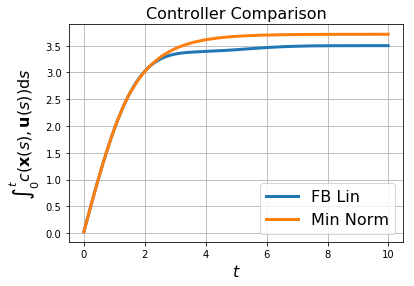

In [4]:
x_0 = array([1, 0])
T = 10
N = 100
ts = linspace(0, T, T * N)

xs, us = system.simulate(x_0, fb_lin, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_fb_lin = (xs, lqr_costs)

xs, us = system.simulate(x_0, qp, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_qp = (xs, lqr_costs)

figure()
title('Controller Comparison', fontsize=16)
xs, lqr_costs = data_fb_lin
plot(ts, xs[:, :n], linewidth=3, label='FB Lin')
xs, lqr_costs = data_qp
plot(ts, xs[:, :n], linewidth=3, label='Min Norm')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\\mathbf{q}$', fontsize=16)
show()

figure()
title('Controller Comparison', fontsize=16)
xs, lqr_costs = data_fb_lin
plot(ts[:-1], lqr_costs, linewidth=3, label='FB Lin')
xs, lqr_costs = data_qp
plot(ts[:-1], lqr_costs, linewidth=3, label='Min Norm')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\int_{0}^t c(\mathbf{x}(s), \mathbf{u}(s)) \mathrm{d}s$', fontsize=16)
show()

The controllers perform similarly; this is because for nonlinear systems, the greedy QP controller is not optimal in terms of running cost. However, since we are unable to tractably optimize running cost a priori, we will focus on applying the QP controller to robotic systems.

Now consider the setting in which we only have estimates of inertia $\mb{D}$, Coriolis and gravity terms $\mb{H}$, and static actuation matrix $\mb{B}$. Specifically, let $\widehat{\mb{D}}: \mathcal{Q}_0 \to \bb{S}^n_{++}$, $\widehat{\mb{H}}: \mathcal{Q} \times \R^n \to \R^n$, and $\widehat{\mb{B}} \in \R^{n \times n}$ be estimates of these terms, respectively. We assume that $\widehat{\mb{D}}(\mb{q})$ and $\widehat{\mb{D}}(\mb{q})$ are positive-definite for coordinates $\mb{q}$ in the same set $\mathcal{Q}_0$. Additionally, we assume that $\widehat{\mb{B}}$ is full-rank. The dynamics can then be expressed in terms of the estimates as:

\begin{equation}
    \der{}{t} \begin{bmatrix} \mb{q} \\ \dot{\mb{q}} \end{bmatrix} = \begin{bmatrix} \dot{\mb{q}} \\ -\widehat{\mb{D}}(\mb{q})^{-1}\widehat{\mb{H}}(\mb{q}, \dot{\mb{q}}) \end{bmatrix} + \begin{bmatrix} \mb{0}_{n \times n} \\ \widehat{\mb{D}}(\mb{q})^{-1}\widehat{\mb{B}} \end{bmatrix}\mb{u} + \begin{bmatrix} \mb{0}_n \\ -(\mb{D}(\mb{q})^{-1}\mb{H}(\mb{q}, \dot{\mb{q}}) - \widehat{\mb{D}}(\mb{q})^{-1}\widehat{\mb{H}}(\mb{q}, \dot{\mb{q}})) \end{bmatrix} + \begin{bmatrix} \mb{0}_{n \times n} \\ ( \mb{D}(\mb{q})^{-1}\mb{B} -  \widehat{\mb{D}}(\mb{q})^{-1}\widehat{\mb{B}}) \end{bmatrix}\mb{u},
\end{equation}

Due to the assumptions on $\widehat{\mb{D}}$ and $\widehat{\mb{B}}$, a linearizing feedback controller exists (though we are unable to specify it) inducing the same linear dynamics, resulting in the same Lyapunov function. Since we know the induced linear dynamics, we can use the same Lyapunov function with the estimated system. The time-derivative of this Lyapunov function, however, will be unknown.

For the inverted pendulum system, we assume that $m$ and $l$ are unknown; instead we have access to estimates $\widehat{m}$ and $\widehat{l}$ satisfying $\abs{ m - \widehat{m} } \leq M_m$ and $\abs{ l - \widehat{l} } \leq M_l$, for known bounds $M_m, M_l \geq 0$. Note that:

\begin{align}
    \nrm{ \mb{D}(\mb{q})^{-1}\mb{H}(\mb{q}, \dot{\mb{q}}) - \widehat{\mb{D}}(\mb{q})^{-1}\widehat{\mb{H}}(\mb{q}, \dot{\mb{q}}) }_2 &= \abs{g\left(\frac{1}{l} - \frac{1}{\widehat{l}}\right)\sin{\theta}}\\ 
    &\leq g \abs{\frac{1}{l} - \frac{1}{\widehat{l}}}\\
    &\leq g \min{\left\{ \abs{\frac{1}{\widehat{l} - M_l} - \frac{1}{\widehat{l}}}, \abs{\frac{1}{\widehat{l} + M_l} - \frac{1}{\widehat{l}}} \right\}}\\
    &= g \min{\left\{ \abs{\frac{M_l}{(\widehat{l} - M_l)\widehat{l}}}, \abs{\frac{-M_l}{(\widehat{l} + M_l)\widehat{l}}} \right\}}\\
    &= \frac{M_l g}{(\widehat{l} - M_l)\widehat{l}},
\end{align}

and:

\begin{align}
    \nrm{ \mb{D}(\mb{q})^{-1}\mb{B} -  \widehat{\mb{D}}(\mb{q})^{-1}\widehat{\mb{B}} }_2 &= \abs{ \frac{1}{ml^2} - \frac{1}{\widehat{m}\widehat{l}^2} }\\
    &\leq \min{\left\{ \abs{ \frac{1}{(\widehat{m} \pm M_m)(\widehat{l} \pm M_l)^2} - \frac{1}{\widehat{m}\widehat{l}^2} } \right\}}
\end{align}

Now, assume the estimated inverted pendulum system has parameters $\widehat{m} = 0.25$ and $\widehat{l} = 0.5$, and the true system has other parameters $m$ and $l$, varying between $25$% and $50$% of the estimated values. We simulate the true system using the linearizing feedback and QP controllers obtained from the estimated system.

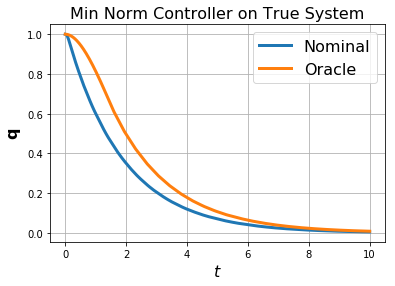

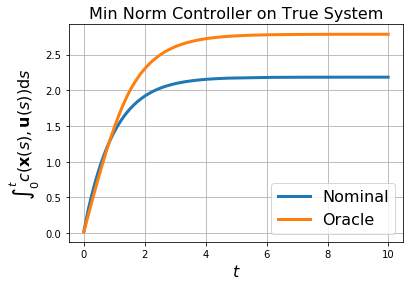

In [5]:
m_hat = m
l_hat = l

m = m_hat + sign(rand() - 0.5) * 0.25 * (rand() + 1) * m
l = l_hat + sign(rand() - 0.5) * 0.25 * (rand() + 1) * l

system_true = InvertedPendulum(m, l, g)
system_est = InvertedPendulum(m_hat, l_hat, g)

qp_true = MinNormController.build(system_true, Q, R)
qp_est = MinNormController.build(system_est, Q, R)

xs, us = system_true.simulate(x_0, qp_true, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_qp_true = (xs, lqr_costs)

xs, us = system_true.simulate(x_0, qp_est, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_qp_est = (xs, lqr_costs)

figure()
title('Min Norm Controller on True System', fontsize=16)
xs, lqr_costs = data_qp_est
plot(ts, xs[:, :n], linewidth=3, label='Nominal')
xs, lqr_costs = data_qp_true
plot(ts, xs[:, :n], linewidth=3, label='Oracle')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\\mathbf{q}$', fontsize=16)
show()

figure()
title('Min Norm Controller on True System', fontsize=16)
xs, lqr_costs = data_qp_est
plot(ts[:-1], lqr_costs, linewidth=3, label='Nominal')
xs, lqr_costs = data_qp_true
plot(ts[:-1], lqr_costs, linewidth=3, label='Oracle')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\int_{0}^t c(\mathbf{x}(s), \mathbf{u}(s)) \mathrm{d}s$', fontsize=16)
show()

The oracle controller outperforms the estimated controller. However, we can learn better representations of the dynamics as we did for linear systems. We will simulate the system using a random controller that samples Gaussian perturbations around the QP controller. However, first observe the behavior of the QP controller.

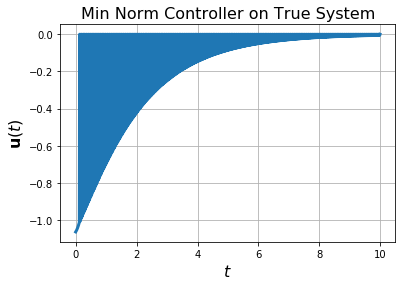

In [6]:
figure()
title('Min Norm Controller on True System', fontsize=16)
xs, lqr_costs = data_qp_est
plot(ts[:-1], us, linewidth=3)
grid()
xlabel('$t$', fontsize=16)
ylabel('$\\mathbf{u}(t)$', fontsize=16)
show()

The control gates to $\mb{0}_n$ whenever it estimates that $\dot{V}(\mb{x}, \mb{0}_n) < \mb{x}^\top\mb{Q}\mb{x}$. This rapid switching will introduce error when we try to differentiate the observed state trajectory. Therefore, we instead implement a smoothed QP controller:

\begin{align}
    \mb{u}_{QP}(\mb{x}, \mb{u}') = \inf_{\mb{u} \in \R^n} ~&~ \mb{u}^\top\mb{R}\mb{u} + \sigma^2 \nrm{ \mb{u} - \mb{u}' }_2^2\\
    \mathrm{s.t.} ~&~ \dot{V}(\mb{x}, \mb{u}) \leq -\mb{x}^\top\mb{Q}\mb{x},
\end{align}

for $\sigma \geq 0$. Here, $\mb{u}'$ denotes the previously chosen action. The intermediate terms are modified as:

\begin{align}
    \mathcal{L}(\mb{u}, \lambda; \mb{x}, \mb{u}') &= \mb{u}^\top(\mb{R} + \sigma^2\mb{I}_n)\mb{u} - 2\sigma^2\mb{u}^\top\mb{u}' + \nrm{\mb{u}'}_2^2 + \lambda (\dot{V}(\mb{x}, \mb{u}) + \mb{x}^\top\mb{Q}\mb{x}),\\
    \mb{u}^*(\lambda; \mb{x}, \mb{u}') &= -\frac{1}{2}(\mb{R} + \sigma^2 \mb{I}_n)^{-1} (\lambda \mb{g}(\mb{x})^\top V(\mb{x}) - 2\sigma^2 \mb{u}'),\\
    h(\lambda; \mb{x}, \mb{u}') &= -\frac{1}{4} (\lambda \mb{g}(\mb{x})^\top V(\mb{x}) - 2\sigma^2 \mb{u}')^\top (\mb{R} + \sigma^2 \mb{I}_n)^{-1} (\lambda \mb{g}(\mb{x})^\top V(\mb{x}) - 2\sigma^2 \mb{u}') + \nrm{\mb{u}'}_2^2 + \lambda (\dot{V}(\mb{x}, \mb{0}_n) + \mb{x}^\top\mb{Q}\mb{x}),\\
    \lambda^*(\mb{x}, \mb{u}') &= \begin{cases}
        2 \frac{\sigma^2 \nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{u}' + \dot{V}(\mb{x}, \mb{0}_n) + \mb{x}^\top\mb{Q}\mb{x}}{\nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{g}(\mb{x})^\top V(\mb{x})} & \sigma^2 \nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{u}' + \dot{V}(\mb{x}, \mb{0}_n) \geq -\mb{x}^\top\mb{Q}\mb{x}\\
        0 & \sigma^2 \nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{u}' + \dot{V}(\mb{x}, \mb{0}_n) < -\mb{x}^\top\mb{Q}\mb{x}
    \end{cases},
\end{align}

ultimately yielding the controller:

\begin{equation}
    \mb{u}_{QP}(\mb{x}, \mb{u}') = \begin{cases}
        -(\mb{R} + \sigma^2 \mb{I}_n)^{-1} \left( \frac{ \sigma^2 \nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{u}' + \dot{V}(\mb{x}, \mb{0}_n) + \mb{x}^\top\mb{Q}\mb{x} }{\nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{g}(\mb{x})^\top V(\mb{x})} \mb{g}(\mb{x})^\top\nabla V(\mb{x}) -\sigma^2\mb{u}' \right) & \sigma^2 \nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{u}' + \dot{V}(\mb{x}, \mb{0}_n) \geq -\mb{x}^\top\mb{Q}\mb{x}\\
        \sigma^2(\mb{R} + \sigma^2\mb{I}_n)^{-1} \mb{u}' & \sigma^2 \nabla V(\mb{x})^\top\mb{g}(\mb{x})(\mb{R} + \sigma^2 \mb{I}_n)^{-1}\mb{u}' + \dot{V}(\mb{x}, \mb{0}_n) < -\mb{x}^\top\mb{Q}\mb{x}
    \end{cases}
\end{equation}

Observe that when $\sigma = 0$, the resulting controller is equivalent to the unsmoothed case. Therefore we consider $\sigma > 0$. We simulate the system with $\sigma = 10$.

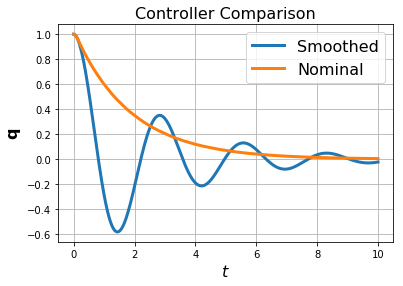

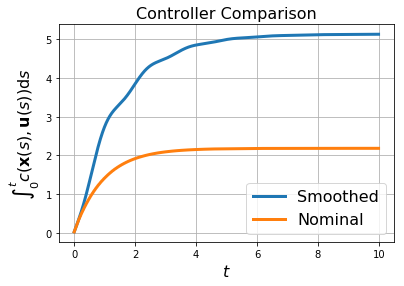

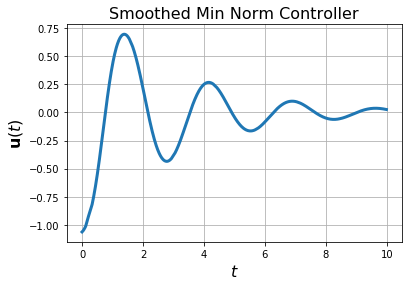

In [7]:
sigma = 10
qp_smooth = MinNormController.build(system_est, Q, R, sigma)

xs, us = system_true.simulate(x_0, qp_smooth, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_qp_smooth = (xs, lqr_costs)

figure()
title('Controller Comparison', fontsize=16)
xs, _ = data_qp_smooth
plot(ts, xs[:, :n], linewidth=3, label='Smoothed')
xs, _ = data_qp_est
plot(ts, xs[:, :n], linewidth=3, label='Nominal')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\\mathbf{q}$', fontsize=16)
show()

figure()
title('Controller Comparison', fontsize=16)
_, lqr_costs = data_qp_smooth
plot(ts[:-1], lqr_costs, linewidth=3, label='Smoothed')
_, lqr_costs = data_qp_est
plot(ts[:-1], lqr_costs, linewidth=3, label='Nominal')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\int_{0}^t c(\mathbf{x}(s), \mathbf{u}(s)) \mathrm{d}s$', fontsize=16)
show()

figure()
title('Smoothed Min Norm Controller', fontsize=16)
plot(ts[:-1], us, linewidth=3)
grid()
xlabel('$t$', fontsize=16)
ylabel('$\\mathbf{u}(t)$', fontsize=16)
show()

Denote the smoothed QP controller as a time-varying state-feedback controller:

\begin{equation}
    \mb{u}_0(\mb{x}, t) = \mb{u}_{QP}(\mb{x}, \mb{u}_0(\mb{x}(t - \Delta t), t - \Delta t)),
\end{equation}

where $\Delta t$ is the sample period. Consider the random controller:

\begin{equation}
    \mb{u}(\mb{x}, t) \sim \mathcal{N}(\mb{u}_0(\mb{x}, t), \bs{\Sigma}),
\end{equation}

for covariance $\bs{\Sigma} \in \bb{S}^n_{++}$. We simulate the system using this controller and numerically differentiate the resulting state trajectory. Here we use $\bs{\Sigma} = (0.01)^2 \cdot \mb{I}_n$. We also sample perturbations at $20$ Hz since we will differentiate the resulting state trajectory.

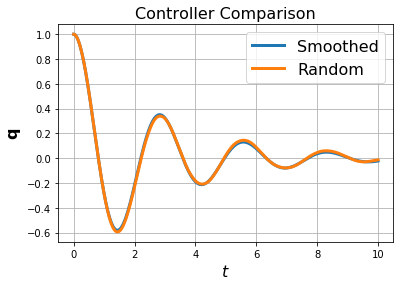

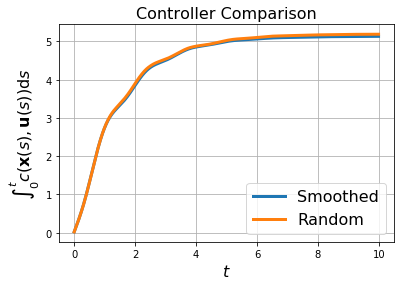

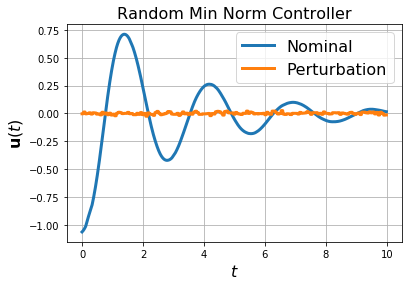

In [8]:
cov = (0.01 ** 2) * identity(n)
reps = 5

qp_rand = RandomController(qp_smooth, cov, reps)

xs, us = system_true.simulate(x_0, qp_rand, ts)
us = array([array([u_nom, u_pert, qp_rand.process((u_nom, u_pert))]) for u_nom, u_pert in us])
lqr_costs = lqr_cost(Q, R, xs, us[:, -1], ts)
data_qp_rand = (xs, lqr_costs)

figure()
title('Controller Comparison', fontsize=16)
xs, _ = data_qp_smooth
plot(ts, xs[:, :n], linewidth=3, label='Smoothed')
xs, _ = data_qp_rand
plot(ts, xs[:, :n], linewidth=3, label='Random')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\\mathbf{q}$', fontsize=16)
show()

figure()
title('Controller Comparison', fontsize=16)
_, lqr_costs = data_qp_smooth
plot(ts[:-1], lqr_costs, linewidth=3, label='Smoothed')
_, lqr_costs = data_qp_rand
plot(ts[:-1], lqr_costs, linewidth=3, label='Random')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\int_{0}^t c(\mathbf{x}(s), \mathbf{u}(s)) \mathrm{d}s$', fontsize=16)
show()

figure()
title('Random Min Norm Controller', fontsize=16)
plot(ts[:-1], us[:, 0], linewidth=3, label='Nominal')
plot(ts[:-1], us[:, 1], linewidth=3, label='Perturbation')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\\mathbf{u}(t)$', fontsize=16)
show()

We numerically differentiate the state trajectory with a centered differentiation filter (window size 3).

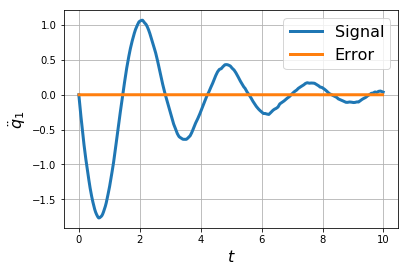

In [9]:
xs = xs[:-1]
us = us[:, -1]
ts = ts[:-1]

x_dots = array([system_true.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
data_compare = (ts, x_dots)

window = 3
half_window = (window - 1) // 2
x_dots = differentiate(xs, ts, window)[::reps]
xs = xs[half_window:-half_window:reps]
us = us[half_window:-half_window:reps]
ts = ts[half_window:-half_window:reps]
data = (xs, us, ts, x_dots)

axs = [figure().add_subplot(111) for _ in range(n, 2 * n)]
for i, ax in enumerate(axs):
    ts, x_dot_compares = data_compare
    ax.plot(ts, x_dot_compares[:, i], linewidth=3, label='Signal')
    _, _, ts, x_dots = data
    ax.plot(ts, x_dot_compares[half_window:-half_window:reps, i] - x_dots[:, i], linewidth=3, label='Error')
    ax.grid()
    ax.legend(fontsize=16)
    ax.set_xlabel('$t$', fontsize=16)
    ax.set_ylabel('$\\ddot{q}_{' + str(i + 1) + '}$', fontsize=16)
    
show()

Recall that the uncertainty in the dynamics is isolated to $\ddot{\mb{q}}$. Therefore, we will fit esimators of the residual error in the last $n$ components of the state derivative estimates. We have a dataset of the form $\{ ((\mb{x}_i, \mb{u}_i), \ddot{\mb{q}}_i) \}_{i=1}^N$. Since we know the residual uncertainty is affine in the control input, we will approximate:

\begin{equation}
    \inf_{\substack{ \widehat{\mb{a}} \in \mathcal{H}_{\mb{a}} \\ \widehat{\mb{b}} \in \mathcal{H}_{\mb{b}} }} \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \nrm{ \ddot{\mb{q}}_i - ( \widehat{\mb{D}}(\mb{q}_i)^{-1}(-\widehat{\mb{H}}(\mb{q}_i, \dot{\mb{q}_i}) + \widehat{\mb{B}}\mb{u}_i) + \widehat{\mb{a}}(\mb{x}_i) + \widehat{\mb{b}}(\mb{x}_i)^\top\mb{u}_i) }_2^2,
\end{equation}

for some model classes $\mathcal{H}_{\mb{a}}$ and $\mathcal{H}_{\mb{b}}$, noting that $\mb{x}_i = (\mb{q}_i, \dot{\mb{q}}_i)$. Model classes $\mathcal{H}_{\mb{a}}$ and $\mathcal{H}_{\mb{b}}$ are composed of state-dependent estimators $\widehat{\mb{a}}: \R^{2n} \to \R^n$ and $\widehat{\mb{b}}: \R^{2n} \to \R^{n \times n}$, respectively. Here, $\mathcal{H}_{\mb{a}}$ and $\mathcal{H}_{\mb{b}}$ are classes of $2$-layer neural networks with $10$ hidden units and ReLU nonlinearities.

In [10]:
from tensorflow.logging import ERROR, set_verbosity
set_verbosity(ERROR)

x_dot_res = array([x_dot - system_est.eval_dot(x, u, t) for x, u, t, x_dot in zip(*data)])
q_ddot_res = x_dot_res[:, :n]
data_fit = (xs, us, q_ddot_res)

def two_layer_nn(dim_in, dim_hidden, shape_out):
    inputs = Input((dim_in,))
    
    outputs = Dense(dim_hidden, activation='relu')(inputs)
    outputs = Dense(product(shape_out))(outputs)
    outputs = Reshape(shape_out)(outputs)
    
    return Model(inputs, outputs)       

def affine_nn(drift_model, act_model):
    _, n = drift_model.input_shape
    _, _, m = act_model.output_shape
    xs = Input((n,))
    us = Input((m,))
    
    drifts = drift_model(xs)
    acts = act_model(xs)
    outputs = Add()([drifts, Dot((2, 1))([acts, us])])
    
    return Model([xs, us], outputs)

d_hidden = 10
drift_res = two_layer_nn(2 * n, d_hidden, (n,))
act_res = two_layer_nn(2 * n, d_hidden, (n, n))
res = affine_nn(drift_res, act_res)

res.compile(optimizer='sgd', loss='mean_squared_error')
_ = res.fit([xs, us], q_ddot_res, epochs=100)

Epoch 1/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 2/100
200/200 [==============================] - 0s 68us/step - loss: 0.0212
Epoch 3/100
200/200 [==============================] - 0s 75us/step - loss: 0.0192
Epoch 4/100
200/200 [==============================] - 0s 83us/step - loss: 0.0172
Epoch 5/100
200/200 [==============================] - 0s 80us/step - loss: 0.0156
Epoch 6/100
200/200 [==============================] - 0s 78us/step - loss: 0.0139
Epoch 7/100
200/200 [==============================] - 0s 78us/step - loss: 0.0122
Epoch 8/100
200/200 [==============================] - 0s 72us/step - loss: 0.0111
Epoch 9/100
200/200 [==============================] - 0s 74us/step - loss: 0.0101
Epoch 10/100
200/200 [==============================] - 0s 81us/step - loss: 0.0093
Epoch 11/100
200/200 [==============================] - 0s 69us/step - loss: 0.0085
Epoch 12/100
200/200 [==============================] - 0s 75us/step - loss: 0.0078
Ep

200/200 [==============================] - 0s 66us/step - loss: 6.8338e-04
Epoch 97/100
200/200 [==============================] - 0s 58us/step - loss: 6.7841e-04
Epoch 98/100
200/200 [==============================] - 0s 63us/step - loss: 6.7450e-04
Epoch 99/100
200/200 [==============================] - 0s 75us/step - loss: 6.6939e-04
Epoch 100/100
200/200 [==============================] - 0s 98us/step - loss: 6.6658e-04
